앞서 진행한 lstm 모델을 이용한 감성분석에서 pred할 sns데이터에 대한 감성분석 정확도가 떨어짐을 확인하였고, 이는 학습데이터의 문제로 확인하였다.

따라서 학습데이터를 naver api를 이용해 감성 파악하고 알맞게 분리됨을 확인한 coupang 데이터로만 사용하여 다시 진행한다.

# 머신러닝 LSTM모델을 이용한 감성분석 진행 02

train : only coupang만!

test: 직접 감성파악한 문장 300 문장 (다수결로 확정) 

pred: 2015, 2020 blog cafe데이터

# colab 환경에서 작성
- konlpy intsall

In [4]:
!apt-get update 
!apt-get install g++ openjdk-8-jdk python-dev python3-dev 
!pip3 install JPype1-py3 
!pip3 install konlpy 
!JAVA_HOME="C:\Program Files\Java\jdk-13.0.2"

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/grap

# 0906 머신러닝 LSTM 모델

## 01. 데이터 불러오기 확인

### - train data 2 : 쿠팡

In [6]:
import pandas as pd
train_df_2 = pd.read_excel('train_data/coupang_naver_total/total_senti_coupang.xlsx') # 데이터 불러오기
print( len(train_df_2) )
train_df_2[0:3] # 확인

15730


,Unnamed: 0,train,api,score
0,0,밥맛하면\n곰곰쌀이죠,neutral,0
1,1,비록 다이어트에 실패를 가져다 준\n곰곰쌀이지만\n맛있는 걸 오또케요\n진짜 최고입니다,positive,1
2,2,♡지난번 구입해서 먹고 다 먹어서\n또 구입했습니다,neutral,0


In [7]:
len(train_df_2)

15730

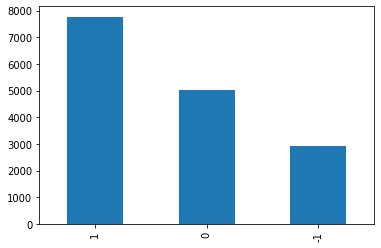

In [8]:
# train data의 긍부정 비율 확인 : 긍정1 / 중립0 / 부정 -1
%matplotlib inline 
import matplotlib.pyplot as plt

train_df_2['score'].value_counts().plot(kind='bar')

### - pred : 2020 카페

In [17]:
# Test 데이터 불러오기
pred_df = pd.read_excel('test_data/2020cafe_clean.xlsx') # header있음 # 전처리 완료된 데이터 문서단위임

In [13]:
# 데이터 확인
pred_df['content']

0       초기이유식 2단계 소고기미음 차례  나는 튼이이유식 책을보고 만들고 있는데  초기는...
1         2020년 1월호 628호  소식지 내용입니다||-||||-||||-|| 건강한...
2        누룩  쌀  효모  쌀막걸리 이번 막걸리 만들기에서는 쌀의 양을 2  에서 3  ...
3       안녕하세요||-|| 해피밍입니다||-||||-||||-||  제가 며칠전 유튜브를 ...
4       아기떡뻥 지후쌀과자 이것만 먹어요||-|| 안녕하세요||-||  글뤽이에요||-||...
                              ...                        
7789    피부트러블이나 장트러블이 있는 사람들은 글루텐에 신경쓰기 마련 둘다 갖고 있는 나도...
7790    집콕생활은 쌀 소비를 촉진시킵니다||-|| 하핫  덕분에 한달넘게 먹을 수 있는 쌀...
7791     201204 웨딩촬영 후 잠시 들렀던 본가에 핸드폰을 두고온 똥멍청이   주말내내...
7792    코로나 확산세가 가속화 되면서 요가 못간지 어언 1개월    확진자는 아니지만 확찐...
7793    항상 쿠팡프레시를 이용해서 장을 보다가 먹고 싶은 게 생겨서 마켓컬리로 주문  배송...
Name: content, Length: 7794, dtype: object

## 02. 데이터 전처리

###  - train data

In [14]:
# train 2 확인 : 쿠팡 데이터

# text 컬럼이 non-null인 샘플만 train_df에 다시 저장
train_df_2 = train_df_2[train_df_2['train'].notnull()]

# 수정된 train_df의 정보를 다시 확인
print(train_df_2.info())

# 분류 클래스의 구성을 확인
print(train_df_2['score'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15730 entries, 0 to 15729
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  15730 non-null  int64 
 1   train       15730 non-null  object
 2   api         15730 non-null  object
 3   score       15730 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 614.5+ KB
None
 1    7771
 0    5035
-1    2924
Name: score, dtype: int64


### - pred set 전처리

In [18]:
# pred에 str이 아닌게 존재하네! nan임을 확인함 # 제거하고 데이터 다시 가져옴
for i in range(len(pred_df)):
    if type(pred_df['content_clean'][i]) != str :
        print(i)

In [19]:
# 댓글이 있는 항목만 담기(빈 댓글 삭제)
# text 컬럼이 non-null인 샘플만 train_df에 다시 저장
pred_df = pred_df[pred_df['content_clean'].notnull()]

# 수정된 train_df의 정보를 다시 확인
print(pred_df.info())

# null값 개수 확인
print(pred_df['content_clean'].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10005 entries, 0 to 10004
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     10005 non-null  int64 
 1   Unnamed: 0.1   10005 non-null  int64 
 2   title          10005 non-null  object
 3   nickname       10005 non-null  object
 4   date           10005 non-null  object
 5   content        10005 non-null  object
 6   comments       9665 non-null   object
 7   content_clean  10005 non-null  object
dtypes: int64(2), object(6)
memory usage: 703.5+ KB
None
0


### - pred: 문서 -> 문장
pred_df['content_clean'][0] # 문서단위로 존재함 -> 문장단위로 바꿈

In [20]:
# contents str로 처리
q= " "
for i in range(len(pred_df)):
    try:
     q += pred_df['content_clean'][i]
    except:
     pass

In [21]:
# 문장어미 구분자 대치
q = q.replace('네요','네요||-||').replace('하죠','하죠||-||').replace('데요','데요||-||').replace('이네요','이네요||-||')
q = q.replace('네요.','네요||-||').replace('되죠','되죠||-||').replace('대요','대요||-||').replace('이요','이요||-||')
q = q.replace('돼요.','돼요||-||').replace('되요','되요||-||').replace('다닙니다','다닙니다||-||').replace('입니다','입니다||-||')
q = q.replace('입니다.','입니다||-||').replace('니다','니다||-||').replace('중입니다','중입니다||-||').replace('입니다','입니다||-||')
q = q.replace('나요.','나요||-||').replace('어요','어요||-||').replace('까요','까요||-||').replace('에요','에요||-||')
q = q.replace('이에요','이에요||-||').replace('봐요','봐요||-||').replace('아요.','아요||-||').replace('와요','와요||-||')
q = q.replace('해요','해요||-||').replace('려요','려요||-||').replace('구요','구요||-||').replace('고요','고요||-||')
q = q.replace('죠','죠||-||').replace(':)','').replace('더라','더라||-||').replace('게요','게요||-||').replace('께요','께요||-||').replace('세요','세요||-||').replace('든요','든요||-||').replace('예요','예요||-||').replace('서요','서요||-||')
q = q.replace('않았다','않았다||-||').replace('었다','었다||-||').replace('있다','있다||-||').replace('이다','이다||-||').replace('싶다','싶다||-||').replace('않다','않다||-||').replace('되었다','되었다||-||').replace('아니다','아니다||-||')
q = q.replace('하자','하자||-||').replace('는다','는다||-||').replace('했다','했다||-||').replace('한다','한다||-||').replace('혔다','혔다||-||').replace('난다','난다||-||').replace('같아요','같아요||-||').replace('되었어','되었어||-||').replace('했어','했어||-||').replace('했지','했지||-||').replace('었어','었어||-||')

#특수문자 제거
q = q.replace('.','').replace('?','').replace('~','').replace('!','').replace('^','').replace('#','').replace('★','').replace('ㅋ','').replace('ㅜ','').replace('ㅠ','').replace('ㅎ','').replace('ㅏ','').replace('ㅡ','')

# 구분자로 문장 분리
p = q.split('||-||')
print ( '분리된 문장 수 : ',len(p), '// 이전 총 문자수 : ',len(q) ) 

# 각 문장을 데이터 프레임으로 저장
sentence_Data = pd.DataFrame({'content': p})
print ( len(sentence_Data) ) 
sentence_Data # pred할 셋 문장단위 설정 완

분리된 문장 수 :  48332 // 이전 총 문자수 :  2010402
48332


,content
0,쌀구움과자 장여진 채미희 지음경향미디어메마른 쌀베이킹계의...
1,쌀베이킹을 하면서밀베이킹과는 조금다른 결과물에당황할 때도 종종 있거든요
2,클래스를 다녀야하나 고민도해봤는데시간이 없는 저로썬 집에서 끙끙 앓고 있었는데너...
3,프롤로그 쌀베이킹을 시작한 이유에 대해 적혀져있어요
4,떡으로 시작해서 베이킹까지 여러재료를 활용하고 다양한 가루를사용하셨다고 해요
...,...
48327,...
48328,윤기 좔좔 맛있는 평택쌀 쌀 추청 20 58 000원 54 000...
48329,재난기금카드 돌봄쿠폰 카드결제 대면결제 계좌이체 온누리상품권 현금영수증 ...
48330,전화문의 010 2856 8020 계좌 582 12 053282 농협 장유...


### - 문장단위 데이터 전처리

In [22]:
# 2번 이상 중복인 데이터 확인
sentence = sentence_Data['content'].value_counts()
idx_sentence=sentence[sentence >= 2].index.tolist()
len(idx_sentence), idx_sentence

(684,
 ['',
  '요',
  '구요',
  '고요',
  '     공유소스 코드                                   주소복사     소스544   306740   416936   5261280   720복사      미지원으로        코드 퍼가기 기능은 더 이상 지원되지않습니다',
  '360       도움말            멀티트랙의 트랙별 영상은 우측 관련영상에서 볼 수 있습니다',
  ' 5분 이상 소요될 수 있으며  영상의 길이에 따라 소요 시간은 달라집니다',
  ' 안녕하세요',
  '  안녕하세요',
  '  감사합니다',
  '안녕하세요',
  ' 감사합니다',
  '   안녕하세요',
  '네요',
  '   감사합니다',
  '  복지 질문 금지   일상 속 이야기들을 작성하는 게시판 입니다',
  '고 하네요',
  '고 합니다',
  '당신의 한마디가 카페를 만들어갑니다',
  ' 질문자 답변자 간의 기본매너를 지켜주세요',
  ' 질문의 정보가 부정확할 경우  제한된 답변을 받을 수 있습니다',
  '    안녕하세요',
  '고 해요',
  '고 한다',
  '고 하더라',
  '  추천은 저에게 힘이 됩니다',
  '  백진주는 작년 출시후 올해 2월에 전량 판매 마감을 했습니다',
  '                                                         2            3                0   0                   0                    0                                                                               0 0 도움말라이센스                        4 17 48                  2020 2 12                 동영상 인코딩 중입니다',
  '  강화도에서 백진주를 작년 처음 재배했고  

In [23]:
# 중복제거
data2 = sentence_Data
for i in idx_sentence:
    data2 = data2[sentence_Data['content'] != i] # 중복 완료해서 저장
# 데이터 사이즈 확인
print ('중복제거 전 데이터: ', len(sentence_Data), '중복제거완료 데이터: ', len(data2) ) #중복제거 전 데이터, 중복제거완료 데이터   
# null 확인
print( data2.isnull().sum() )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


중복제거 전 데이터:  48332 중복제거완료 데이터:  37243
content    0
dtype: int64


In [24]:
data2 # 인덱스 정렬 재필요해 보임

,content
0,쌀구움과자 장여진 채미희 지음경향미디어메마른 쌀베이킹계의...
1,쌀베이킹을 하면서밀베이킹과는 조금다른 결과물에당황할 때도 종종 있거든요
2,클래스를 다녀야하나 고민도해봤는데시간이 없는 저로썬 집에서 끙끙 앓고 있었는데너...
3,프롤로그 쌀베이킹을 시작한 이유에 대해 적혀져있어요
4,떡으로 시작해서 베이킹까지 여러재료를 활용하고 다양한 가루를사용하셨다고 해요
...,...
48327,...
48328,윤기 좔좔 맛있는 평택쌀 쌀 추청 20 58 000원 54 000...
48329,재난기금카드 돌봄쿠폰 카드결제 대면결제 계좌이체 온누리상품권 현금영수증 ...
48330,전화문의 010 2856 8020 계좌 582 12 053282 농협 장유...


In [25]:
data_content = data2[['content']].dropna(axis=0) # null 제거
data_content.reset_index(drop=True, inplace=True) # 인덱스 재정렬
data_content

,content
0,쌀구움과자 장여진 채미희 지음경향미디어메마른 쌀베이킹계의...
1,쌀베이킹을 하면서밀베이킹과는 조금다른 결과물에당황할 때도 종종 있거든요
2,클래스를 다녀야하나 고민도해봤는데시간이 없는 저로썬 집에서 끙끙 앓고 있었는데너...
3,프롤로그 쌀베이킹을 시작한 이유에 대해 적혀져있어요
4,떡으로 시작해서 베이킹까지 여러재료를 활용하고 다양한 가루를사용하셨다고 해요
...,...
37238,...
37239,윤기 좔좔 맛있는 평택쌀 쌀 추청 20 58 000원 54 000...
37240,재난기금카드 돌봄쿠폰 카드결제 대면결제 계좌이체 온누리상품권 현금영수증 ...
37241,전화문의 010 2856 8020 계좌 582 12 053282 농협 장유...


In [26]:
# pred에 str이 아닌게 존재하네! nan임을 확인함 # 제거하고 데이터 다시 가져옴
for i in range(len(data2)):
    if type(data_content['content'][i]) != str :
        print(i) # null없음 확인 땅땅!

## 03. train / test 분리

### -case 1) train / test split

In [28]:
# Train용 데이터셋과 Test용 데이터 셋 분리
# 예측력을 높이기 위해 수집된 데이터를 학습용과 테스트 용으로 분리하여 진행

from sklearn.model_selection import train_test_split
# train_x, test_x, train_y, test_y = train_test_split(train_df[0], train_df[1] , test_size=0.2, random_state=0)  # 현대만 학습
train_x, test_x, train_y, test_y = train_test_split(train_df_2['train'], train_df_2['score'] , test_size=0.2, random_state=0) # 현대 쿠팡학습

print(len(train_x), len(train_y), len(test_x), len(test_y))

12584 12584 3146 3146


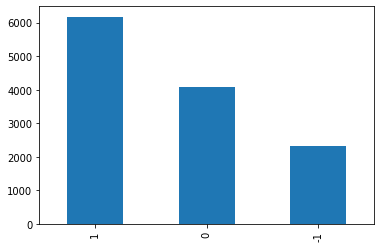

In [29]:
# train data의 긍부정 비율 확인 : 긍정1 / 중립0 / 부정 -1
%matplotlib inline 
import matplotlib.pyplot as plt

train_y.value_counts().plot(kind='bar')

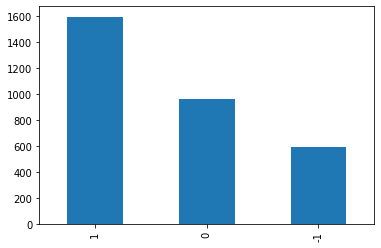

In [30]:
test_y.value_counts().plot(kind='bar')

### - case2) train: 쿠팡 / test: 300st

In [33]:
#01. 데이터 불러오기
retest_data = pd.read_excel('test_data/retest300st.xlsx')
retest_data

#02. 전처리
# retest_data의 test 칼럼을 긍정 1, 중립0 부정 -1로 교체
y_score=[]
for i in range(len(retest_data)):
    if retest_data['test'][i] == '부정':
        y_score.append(-1)
    elif retest_data['test'][i] == '중립':
        y_score.append(0)
    else:
        y_score.append(1)

In [35]:
# Train용 데이터셋과 Test용 데이터 셋 분리
# test_x와 test_y 교체

train_x = train_df_2['train']
train_y =train_df_2['score']
test_x = retest_data['content'].astype(str)
test_y = y_score

print(len(train_x), len(train_y), len(test_x), len(test_y))
print(type(train_x), type(train_y), type(test_x), type(test_y))

15730 15730 300 300
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'list'>


## => case2 로 진행하기로함!

## 04. 토큰화 및 벡터화

### - x_토큰화

In [36]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [37]:
import konlpy 
from konlpy.tag import Okt 
okt = Okt() 
X_train = [] 
for sentence in train_x:
    temp_X = [] 
    temp_X = okt.morphs(sentence, stem=True) # 토큰화 
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 
    X_train.append(temp_X) 
    
X_test = [] 
for sentence in test_x:
    temp_X = [] 
    temp_X = okt.morphs(sentence, stem=True) # 토큰화 
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 
    X_test.append(temp_X)


### - x_정수 인코딩

In [38]:
# 정수 인코딩
from keras.preprocessing.text import Tokenizer 
max_words = 35000 
tokenizer = Tokenizer(num_words = max_words) 
tokenizer.fit_on_texts(X_train) 
X_train = tokenizer.texts_to_sequences(X_train) 
X_test = tokenizer.texts_to_sequences(X_test)

train 최대 길이 :  375
train 평균 길이 :  11.4092180546726


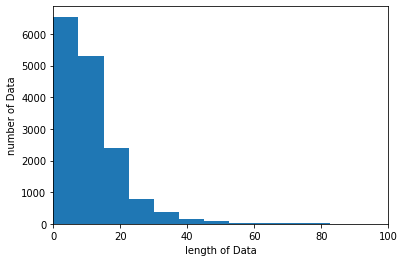

In [39]:
# x 길이 확인
print("train 최대 길이 : ", max(len(l) for l in X_train)) 
print("train 평균 길이 : ", sum(map(len, X_train))/ len(X_train)) 

plt.xlim([0, 100]) 
plt.hist([len(s) for s in X_train], bins=50) 
plt.xlabel('length of Data') 
plt.ylabel('number of Data') 
plt.show()

### - y 원핫인코딩

In [42]:
# one- hot  encoding
import numpy as np 
y_train = [] 
y_test = [] 

for i in range(len(train_y)):
    if train_y.iloc[i] == 1: 
        y_train.append([0, 0, 1]) 
    elif train_y.iloc[i] == 0: 
        y_train.append([0, 1, 0]) 
    elif train_y.iloc[i] == -1: 
        y_train.append([1, 0, 0]) 

for i in range(len(test_y)): 
    if test_y[i] == 1: 
        y_test.append([0, 0, 1]) 
    elif test_y[i] == 0: 
        y_test.append([0, 1, 0]) 
    elif test_y[i] == -1: 
        y_test.append([1, 0, 0]) 
        
y_train = np.array(y_train) 
y_test = np.array(y_test)

test 최대 길이 :  72
test 평균 길이 :  11.016666666666667


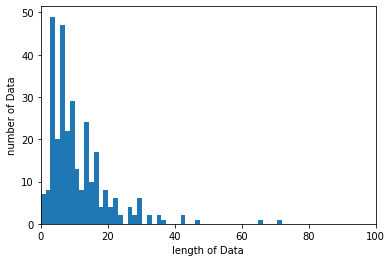

In [43]:
# y 길이확인
print("test 최대 길이 : ", max(len(l) for l in X_test)) 
print("test 평균 길이 : ", sum(map(len, X_test))/ len(X_test)) 

plt.xlim([0, 100]) 
plt.hist([len(s) for s in X_test], bins=50) 
plt.xlabel('length of Data') 
plt.ylabel('number of Data') 
plt.show()

## 05. 모델 생성 / 학습 / 평가

In [44]:
from keras.layers import Embedding, Dense, LSTM 
from keras.models import Sequential 
from keras.preprocessing.sequence import pad_sequences
max_len = 20 # 전체 데이터의 길이를 20로 맞춘다 
 
X_train = pad_sequences(X_train, maxlen=max_len) 
X_test = pad_sequences(X_test, maxlen=max_len)

In [45]:
model = Sequential() 
model.add(Embedding(max_words, 100)) 
model.add(LSTM(128)) 
model.add(Dense(3, activation='softmax')) 

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])  #optimizer: rmsprop
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.1)

Epoch 1/10
1416/1416 [==============================] - 54s 36ms/step - loss: 0.6526 - accuracy: 0.7228 - val_loss: 0.5593 - val_accuracy: 0.7648
Epoch 2/10
1416/1416 [==============================] - 49s 35ms/step - loss: 0.4857 - accuracy: 0.8082 - val_loss: 0.5226 - val_accuracy: 0.7985
Epoch 3/10
1416/1416 [==============================] - 49s 35ms/step - loss: 0.4307 - accuracy: 0.8316 - val_loss: 0.4999 - val_accuracy: 0.8036
Epoch 4/10
1416/1416 [==============================] - 50s 35ms/step - loss: 0.3833 - accuracy: 0.8512 - val_loss: 0.5442 - val_accuracy: 0.8137
Epoch 5/10
1416/1416 [==============================] - 51s 36ms/step - loss: 0.3402 - accuracy: 0.8712 - val_loss: 0.5198 - val_accuracy: 0.8150
Epoch 6/10
1416/1416 [==============================] - 50s 35ms/step - loss: 0.3032 - accuracy: 0.8883 - val_loss: 0.5257 - val_accuracy: 0.8061
Epoch 7/10
1416/1416 [==============================] - 50s 35ms/step - loss: 0.2654 - accuracy: 0.9026 - val_loss: 0.5272 -

In [58]:
print('model1 전체정확도 : {:.2f}%'.format(model.evaluate(X_test, y_test)[1]*100 ))

10/10 [==============================] - 0s 11ms/step - loss: 1.4568 - accuracy: 0.6233
model1 전체정확도 : 62.33%


In [59]:
model2 = Sequential() 
model2.add(Embedding(max_words, 100)) 
model2.add(LSTM(128)) 
model2.add(Dense(3, activation='softmax')) 

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
history = model2.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.1)

Epoch 1/10
1416/1416 [==============================] - 99s 67ms/step - loss: 0.6159 - accuracy: 0.7479 - val_loss: 0.5103 - val_accuracy: 0.7978
Epoch 2/10
1416/1416 [==============================] - 90s 63ms/step - loss: 0.3987 - accuracy: 0.8437 - val_loss: 0.5033 - val_accuracy: 0.8086
Epoch 3/10
1416/1416 [==============================] - 88s 62ms/step - loss: 0.2932 - accuracy: 0.8897 - val_loss: 0.5305 - val_accuracy: 0.7991
Epoch 4/10
1416/1416 [==============================] - 88s 62ms/step - loss: 0.2212 - accuracy: 0.9172 - val_loss: 0.5806 - val_accuracy: 0.8017
Epoch 5/10
1416/1416 [==============================] - 85s 60ms/step - loss: 0.1659 - accuracy: 0.9397 - val_loss: 0.6367 - val_accuracy: 0.8137
Epoch 6/10
1416/1416 [==============================] - 88s 62ms/step - loss: 0.1193 - accuracy: 0.9564 - val_loss: 0.7308 - val_accuracy: 0.7959
Epoch 7/10
1416/1416 [==============================] - 87s 61ms/step - loss: 0.0915 - accuracy: 0.9674 - val_loss: 0.8416 -

In [60]:
print('model2 전체 정확도 : {:.2f}%'.format(model2.evaluate(X_test, y_test)[1]*100 ))

10/10 [==============================] - 0s 9ms/step - loss: 2.3467 - accuracy: 0.6000
model2 전체 정확도 : 60.00%


In [61]:
# model1
print('model1 정확도 : {:.2f}%'.format(model.evaluate(X_test[0:100], y_test[0:100])[1]*100 ))
print('model1 정확도 : {:.2f}%'.format(model.evaluate(X_test[100:200], y_test[100:200])[1]*100 ))
print('model1 정확도 : {:.2f}%'.format(model.evaluate(X_test[200:300], y_test[200:300])[1]*100 ))

mean_md1= ( model.evaluate(X_test[0:100], y_test[0:100])[1]*100  + model.evaluate(X_test[100:200], y_test[100:200])[1]*100 + model.evaluate(X_test[200:300], y_test[200:300])[1]*100  ) /3
print('model1의 정확도 평균 :',round(mean_md1,2),'%' )

# model2
print('model2 정확도 : {:.2f}%'.format(model2.evaluate(X_test[0:100], y_test[0:100])[1]*100 ))
print('model2 정확도 : {:.2f}%'.format(model2.evaluate(X_test[100:200], y_test[100:200])[1]*100 ))
print('model2 정확도 : {:.2f}%'.format(model2.evaluate(X_test[200:300], y_test[200:300])[1]*100 ))

mean_md2= ( model2.evaluate(X_test[0:100], y_test[0:100])[1]*100  + model2.evaluate(X_test[100:200], y_test[100:200])[1]*100 + model2.evaluate(X_test[200:300], y_test[200:300])[1]*100  ) /3
print('model2의 정확도 평균 :',round(mean_md2,2),'%' )

4/4 [==============================] - 0s 10ms/step - loss: 1.2141 - accuracy: 0.6900
model1 정확도 : 69.00%
4/4 [==============================] - 0s 8ms/step - loss: 1.5084 - accuracy: 0.6000
model1 정확도 : 60.00%
4/4 [==============================] - 0s 8ms/step - loss: 1.6480 - accuracy: 0.5800
model1 정확도 : 58.00%
4/4 [==============================] - 0s 8ms/step - loss: 1.6480 - accuracy: 0.5800
model1의 정확도 평균 : 62.33 %
4/4 [==============================] - 0s 9ms/step - loss: 1.9456 - accuracy: 0.6200
model2 정확도 : 62.00%
4/4 [==============================] - 0s 8ms/step - loss: 2.4303 - accuracy: 0.6300
model2 정확도 : 63.00%
4/4 [==============================] - 0s 8ms/step - loss: 2.6642 - accuracy: 0.5500
model2 정확도 : 55.00%
4/4 [==============================] - 0s 8ms/step - loss: 2.6642 - accuracy: 0.5500
model2의 정확도 평균 : 60.0 %


## 06. pred set 예측 확인 (2015/ 2020 sns 감성분석진행)

In [62]:
for num in range(4): #4번 반복 작업수행
# 데이터 지정 
  if num ==0: # 2020blog
    pred_df = pd.read_excel('test_data/0902_2020_blog.xlsx') # header있음 # 전처리 완료된 데이터 문서단위임
    pred_df0= pred_df
  if num ==1: # 2020cafe
    pred_df = pd.read_excel('test_data/2020cafe_clean.xlsx') # header있음 # 전처리 완료된 데이터 문서단위임
    pred_df1= pred_df
  if num ==2: # 2015blog
    pred_df = pd.read_excel('test_data/0902_2015_blog.xlsx') # header있음 # 전처리 완료된 데이터 문서단위임
    pred_df2= pred_df
  if num ==3: # 2015 cafe
    pred_df = pd.read_excel('test_data/0902_2015_cafe.xlsx') # header있음 # 전처리 완료된 데이터 문서단위임
    pred_df3= pred_df

#데이터 전처리
  # contents str로 처리
  q= " "
  for i in range(len(pred_df)):
      try:
        q += pred_df['content'][i]  
      except:
        pass

  # 문장어미 구분자 대치
  q = q.replace('네요','네요||-||').replace('하죠','하죠||-||').replace('데요','데요||-||').replace('이네요','이네요||-||')
  q = q.replace('네요.','네요||-||').replace('되죠','되죠||-||').replace('대요','대요||-||').replace('이요','이요||-||')
  q = q.replace('돼요.','돼요||-||').replace('되요','되요||-||').replace('다닙니다','다닙니다||-||').replace('입니다','입니다||-||')
  q = q.replace('입니다.','입니다||-||').replace('니다','니다||-||').replace('중입니다','중입니다||-||').replace('입니다','입니다||-||')
  q = q.replace('나요.','나요||-||').replace('어요','어요||-||').replace('까요','까요||-||').replace('에요','에요||-||')
  q = q.replace('이에요','이에요||-||').replace('봐요','봐요||-||').replace('아요.','아요||-||').replace('와요','와요||-||')
  q = q.replace('해요','해요||-||').replace('려요','려요||-||').replace('구요','구요||-||').replace('고요','고요||-||')
  q = q.replace('죠','죠||-||').replace(':)','').replace('더라','더라||-||').replace('게요','게요||-||').replace('께요','께요||-||').replace('세요','세요||-||').replace('든요','든요||-||').replace('예요','예요||-||').replace('서요','서요||-||')
  q = q.replace('않았다','않았다||-||').replace('었다','었다||-||').replace('있다','있다||-||').replace('이다','이다||-||').replace('싶다','싶다||-||').replace('않다','않다||-||').replace('되었다','되었다||-||').replace('아니다','아니다||-||')
  q = q.replace('하자','하자||-||').replace('는다','는다||-||').replace('했다','했다||-||').replace('한다','한다||-||').replace('혔다','혔다||-||').replace('난다','난다||-||').replace('같아요','같아요||-||').replace('되었어','되었어||-||').replace('했어','했어||-||').replace('했지','했지||-||').replace('었어','었어||-||')

  #특수문자 제거
  q = q.replace('.','').replace('?','').replace('~','').replace('!','').replace('^','').replace('#','').replace('★','').replace('ㅋ','').replace('ㅜ','').replace('ㅠ','').replace('ㅎ','').replace('ㅏ','').replace('ㅡ','')

  # 구분자로 문장 분리
  p = q.split('||-||')
  print ( '분리된 문장 수 : ',len(p), '// 이전 총 문자수 : ',len(q) ) 

  # 각 문장을 데이터 프레임으로 저장
  sentence_Data = pd.DataFrame({'content': p})
  print ( len(sentence_Data) ) 
  sentence_Data # pred할 셋 문장단위 설정 완

# 2번 이상 중복인 데이터 확인
  sentence = sentence_Data['content'].value_counts()
  idx_sentence=sentence[sentence >= 2].index.tolist()
  len(idx_sentence), idx_sentence

# 중복제거
  data2 = sentence_Data
  for i in idx_sentence:
      data2 = data2[sentence_Data['content'] != i] # 중복 완료해서 저장
  # 데이터 사이즈 확인
  print ('중복제거 전 데이터: ', len(sentence_Data), '중복제거완료 데이터: ', len(data2) ) #중복제거 전 데이터, 중복제거완료 데이터   

# null 제거
  data_content = data2[['content']].dropna(axis=0) # null 제거
  data_content.reset_index(drop=True, inplace=True) # 인덱스 재정렬
  data_content

#pred의 data_content 저장
  data_content.to_excel(f'test_data/st_pred/pred_data_content{num}.xlsx',encoding='utf-8')

  # pred 토큰화 벡터화
  X_pred = [] 
  for sentence in data_content['content'] :
      temp_X = [] 
      temp_X = okt.morphs(sentence, stem=True) # 토큰화 
      temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 
      X_pred.append(temp_X) 

#벡터, 토큰화   
  # 정수 인코딩
  tokenizer.fit_on_texts(X_pred ) 
  X_pred  = tokenizer.texts_to_sequences(X_pred ) 

  # 데이터 길이 맞추기 : padding  씌움
  X_pred = pad_sequences(X_pred, maxlen=max_len)

##model1으로 해보기
  # pred로 감성분석 예측
  predict = model.predict( X_pred )
  predict_labels = np.argmax(predict, axis=1) 

  ## 데이터 확인 
  st, origin, pred =[],[],[]
  # 데이터 직접 비교해보기
  for i in range( len(data_content) ): 
      st.append( data_content['content'].iloc[i] ) ,
      pred.append( predict_labels[i])

  # 2가 긍정 / 1이 중립 / 0이 부정임을 확인
  #0,1,2로 이루어진 pred -1, 0 ,1 로바꾸기
  pnr=[]
  for i in range(len(pred)):
      if pred[i] == 0:
          pnr.append(-1)
      elif pred[i] ==1:
          pnr.append(0)
      else:
          pnr.append(1)
      
  # 데이터프레임 만들기
  total_ex = pd.DataFrame({'문장' : st , '감성':pnr ,'분류:': pred })
  total_ex

  #엑셀로 저장
  total_ex.to_excel(f'cou-lstm/pred_lstm_pnr_{num}.xlsx',encoding='utf-8')

## model2로도 해보기!
  # pred로 감성분석 예측
  predict2 = model.predict( X_pred )
  predict_labels2 = np.argmax(predict2, axis=1) 

  ## 데이터 확인 
  st, origin, pred =[],[],[]
  # 데이터 직접 비교해보기
  for i in range( len(data_content) ): 
      st.append( data_content['content'].iloc[i] ) ,
      pred.append( predict_labels[i])

  # 2가 긍정 / 1이 중립 / 0이 부정임을 확인
  #0,1,2로 이루어진 pred -1, 0 ,1 로바꾸기
  pnr=[]
  for i in range(len(pred)):
      if pred[i] == 0:
          pnr.append(-1)
      elif pred[i] ==1:
          pnr.append(0)
      else:
          pnr.append(1)
      
  # 데이터프레임 만들기
  total_ex = pd.DataFrame({'문장' : st , '감성':pnr ,'분류:': pred })
  total_ex

  #엑셀로 저장
  total_ex.to_excel(f'cou-lstm/pred_lstm_md2_pnr_{num}.xlsx',encoding='utf-8')

분리된 문장 수 :  335670 // 이전 총 문자수 :  10267596
335670


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


중복제거 전 데이터:  335670 중복제거완료 데이터:  134266
분리된 문장 수 :  48949 // 이전 총 문자수 :  1926495
48949


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


중복제거 전 데이터:  48949 중복제거완료 데이터:  37585
분리된 문장 수 :  224842 // 이전 총 문자수 :  7659509
224842


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


중복제거 전 데이터:  224842 중복제거완료 데이터:  92694
분리된 문장 수 :  88910 // 이전 총 문자수 :  2099604
88910


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


중복제거 전 데이터:  88910 중복제거완료 데이터:  36354
